In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.set_random_seed(0)
from tensorflow import keras
import numpy as np
np.random.seed(0)
import itertools
from keras.preprocessing.image import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(tf. __version__)

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_gen = image_dataset_from_directory(directory="/content/drive/MyDrive/PlantDiseaseMediumDataset/train",
                                         image_size=(256, 256))
test_gen = image_dataset_from_directory(directory="/content/drive/MyDrive/PlantDiseaseMediumDataset/valid",
                                        image_size=(256, 256))

resize = Resizing(260,260)
train_gen = train_gen.map(lambda image,label:(resize(image),label))
test_gen  = test_gen.map(lambda image,label:(resize(image),label))

Found 1757 files belonging to 3 classes.
Found 437 files belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB2
efficientnet = EfficientNetB2(weights=None, include_top=False, input_shape=(260, 260, 3)) 

In [ ]:
model_w = keras.models.load_model('/content/drive/MyDrive/pd_h5/pdorft_efficientnetb2_3.h5')

In [ ]:
model_w.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 9, 9, 1408)       7768569   
                                                                 
 flatten (Flatten)           (None, 114048)            0         
                                                                 
 batch_normalization (BatchN  (None, 114048)           456192    
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 114048)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 114048)           456192    
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 114048)            0

In [ ]:
model = keras.Sequential()


model.add(efficientnet)
# 
model.layers[0].set_weights(model_w.layers[0].get_weights())
# The layer is by default trainable
# model.layers[0].trainable = False

# # Add new layers
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
# model.layers[2].set_weights(model_w.layers[2].get_weights())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.BatchNormalization())
# model.layers[4].set_weights(model_w.layers[4].get_weights())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(3, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 9, 9, 1408)       7768569   
                                                                 
 flatten_16 (Flatten)        (None, 114048)            0         
                                                                 
 batch_normalization_32 (Bat  (None, 114048)           456192    
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 114048)            0         
                                                                 
 batch_normalization_33 (Bat  (None, 114048)           456192    
 chNormalization)                                                
                                                                 
 dropout_33 (Dropout)        (None, 114048)          

# **Training the model**

The model has been trained by splitting the epochs into three different sets.

In [ ]:
ep = 3
history = model.fit_generator(train_gen,
          validation_data=test_gen,
          epochs = ep)

Epoch 1/3
55/55 [==============================] - 54s 769ms/step - loss: 0.6809 - accuracy: 0.7769 - val_loss: 0.3511 - val_accuracy: 0.9062
Epoch 2/3
55/55 [==============================] - 40s 719ms/step - loss: 0.2166 - accuracy: 0.9266 - val_loss: 0.1914 - val_accuracy: 0.9519
Epoch 3/3
55/55 [==============================] - 40s 710ms/step - loss: 0.1085 - accuracy: 0.9664 - val_loss: 0.1602 - val_accuracy: 0.9588


In [ ]:
model.save('/content/drive/MyDrive/pd_h5/ft_Or_EfficientNet_PDS_15.h5')

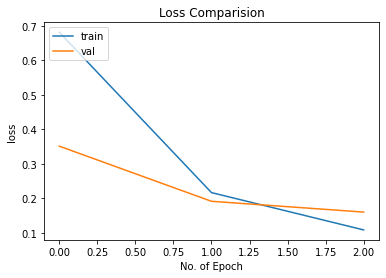

In [ ]:
# training and loss value
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Comparision')
plt.legend(['train','val'],loc='upper left')
plt.xlabel('No. of Epoch')
plt.ylabel('loss')
plt.show()

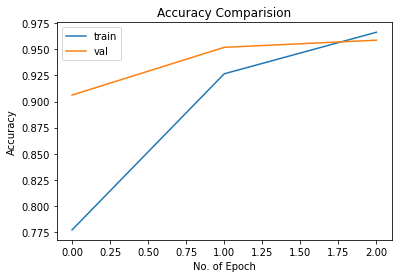

In [ ]:
# training and accuracy value
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Comparision')
plt.legend(['train','val'],loc='upper left')
plt.xlabel('No. of Epoch')
plt.ylabel('Accuracy')
plt.show()



# **Model Testing**

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/pd_h5/pds_effnetb2_6.h5')

In [ ]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

In [ ]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [ ]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 96.64 %
Test Accuracy   : 95.88 %
Precision Score : 95.88 %
Recall Score    : 95.88 %


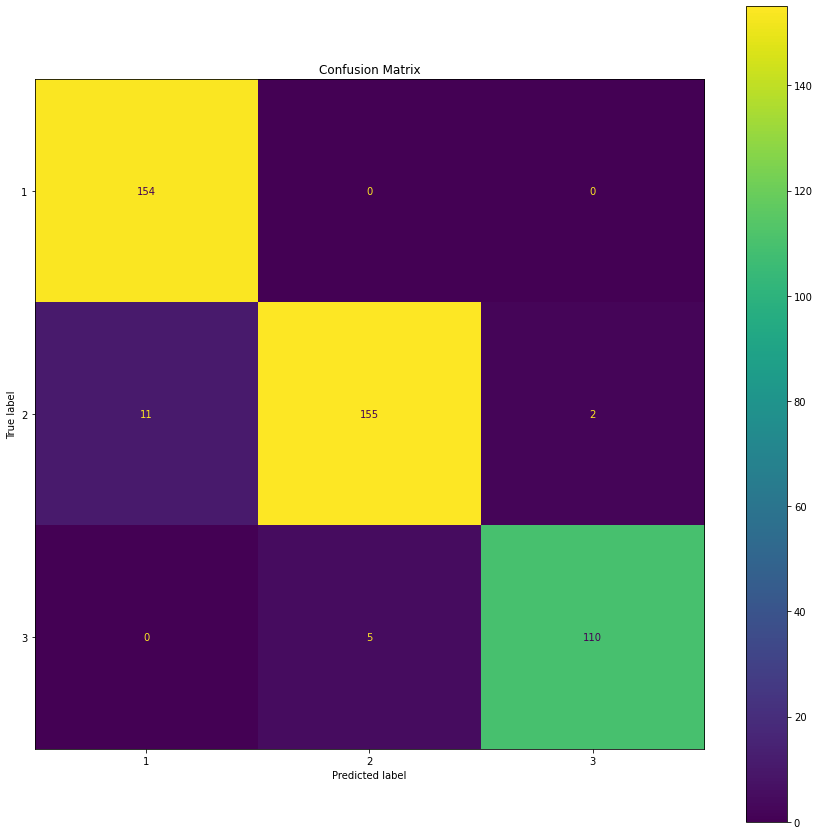

In [ ]:
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,5)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.show()

# **Model Testing with images unkown to the model**

In [ ]:

test_gen_act = image_dataset_from_directory(directory="/content/drive/MyDrive/PlantDiseaseMediumDataset/test_act",
                                        image_size=(256, 256))

# rescale = Rescaling(scale=1.0/255)

# test_gen_act  = test_gen_act.map(lambda image,label:(rescale(image),label))

resize = Resizing(260,260)
test_gen_act = test_gen_act.map(lambda image,label:(resize(image),label))
# test_gen  = test_gen.map(lambda image,label:(resize(image),label))

Found 6 files belonging to 3 classes.


In [ ]:
labels = []
predictions = []
for x,y in test_gen_act:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

In [ ]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [ ]:
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Test Accuracy   : 100.00 %
Precision Score : 100.00 %
Recall Score    : 100.00 %


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import numpy as np
from skimage.color import rgba2rgb
from skimage import data

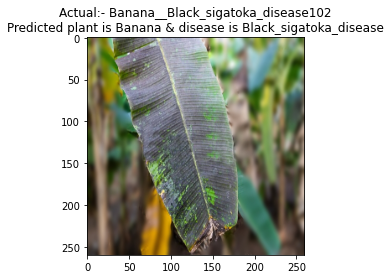

0 0



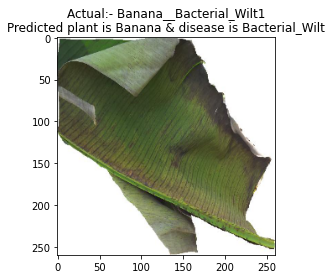

1 1



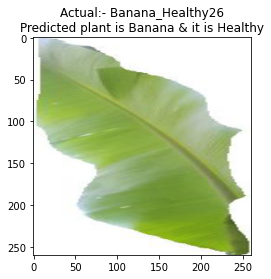

1 2



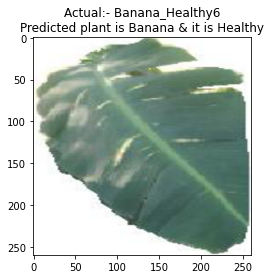

1 3



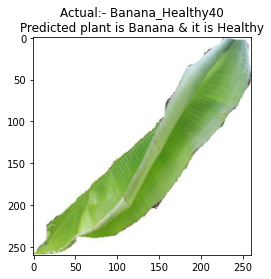

2 4



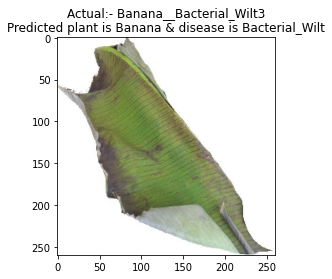

2 5


In [ ]:
# collecting names of images in the test folder
t_path = '/content/drive/MyDrive/PlantDiseaseMediumDataset/test'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(t_path) if isfile(join(t_path, f))]
from os import walk
t_img_names = next(walk(t_path), (None, None, []))[2]

n= len(t_img_names)
diseases=['Banana___Healthy', 'Banana___Bacterial_Wilt','Banana___Black_sigatoka_disease', ]

# fig, axs = plt.subplots(3, 3)
k=0
for i in range(n):
  # Read Image
  img = mpimg.imread(t_path+'/'+t_img_names[i])

  # bringing the image to format used for model training 
  if(img.shape[2]==4):
    img_rgb = rgba2rgb(img)
    # img = img[:,:,:3]

  img3 = cv2.resize(img,(260,260))
  
  img4 = np.reshape(img3,[1,260,260,3])
  
  # using the model to predict disease
  disease = np.argmax(model.predict(img4),axis=1)
  # disease is a list and at 0th index is the disease with highest probability 
  actual = 'Actual:- ' + t_img_names[i][:-4]
  # Splitting the predicted class to plant and disease name.
  plant, dis = diseases[disease[0]].split('___')
  if(dis.lower()=='healthy'):
    finalAnnot = actual + '\n'+"Predicted plant is "+plant+" & it is "+dis
  else:
    finalAnnot = actual + '\n'+"Predicted plant is "+plant+" & disease is "+dis
  # Setting up plt and showing the image used for prediction
  plt.title(finalAnnot)
  plt.imshow(img3)
  plt.show()
  print(k,i)
  if(i%3 == 0):
    k=k+1
  if(i!=(n-1)):
    print('')

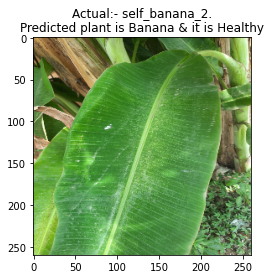

0 0



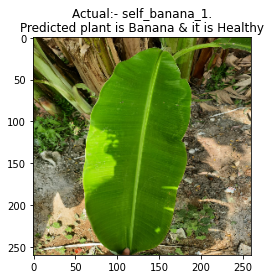

1 1



In [ ]:
# collecting names of images in the test folder
t_path = '/content/drive/MyDrive/PlantDiseaseMediumDataset/self_tests'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(t_path) if isfile(join(t_path, f))]
from os import walk
t_img_names = next(walk(t_path), (None, None, []))[2]

n= len(t_img_names)
diseases=['Banana___Healthy', 'Banana___Bacterial_Wilt','Banana___Black_sigatoka_disease', ]

# fig, axs = plt.subplots(3, 3)
k=0
for i in range(n):
  # Read Image
  img = mpimg.imread(t_path+'/'+t_img_names[i])

  # bringing the image to format used for model training 
  if(img.shape[2]==4):
    img_rgb = rgba2rgb(img)
    # img = img[:,:,:3]

  img3 = cv2.resize(img,(260,260))
  
  img4 = np.reshape(img3,[1,260,260,3])
  
  # using the model to predict disease
  disease = np.argmax(model.predict(img4),axis=1)
  # disease is a list and at 0th index is the disease with highest probability 
  actual = 'Actual:- ' + t_img_names[i][:-4]
  # Splitting the predicted class to plant and disease name.
  plant, dis = diseases[disease[0]].split('___')
  if(dis.lower()=='healthy'):
    finalAnnot = actual + '\n'+"Predicted plant is "+plant+" & it is "+dis
  else:
    finalAnnot = actual + '\n'+"Predicted plant is "+plant+" & disease is "+dis
  # Setting up plt and showing the image used for prediction
  plt.title(finalAnnot)
  plt.imshow(img3)
  plt.show()
  print(k,i)
  if(i%3 == 0):
    k=k+1
  if(i!=(n-1)):
    print('')

***References***
<br>
1 https://github.com/spMohanty/PlantVillage-Dataset
<br>
2 https://keras.io/api/applications/densenet/#densenet201-function
<br>
3 https://www.kaggle.com/vishnu0399/leaf-disease-classification-cnn-96-accuracy
<br>
4 https://www.tensorflow.org/tutorials/images/transfer_learning
